In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import joblib


In [3]:
# Open the pickle file in read-binary mode
with open("../models/needed_variables.pkl", "rb") as f:
    data = joblib.load(f)

with open("../models/needed_variables2.pkl", "rb") as f:
    data2 = joblib.load(f)

# Open the pickle file in read-binary mode
with open("../models/step2_catboost_timesplit.pkl", "rb") as f:
    catboost = joblib.load(f)

print(data)

{'X_test':         num__annual_inc  num__avg_cur_bal  num__bc_open_to_buy  num__bc_util  \
951469        -0.908541         -0.684762            -0.655219      1.311575   
951470        -0.414255          0.993807             0.145469      0.201937   
951471        -0.505971         -0.486715             0.213401     -0.598282   
951472         0.054126          0.329806            -0.415431     -0.971717   
951473        -0.278432         -0.576017            -0.602115      1.293792   
...                 ...               ...                  ...           ...   
985662        -0.418456         -0.612487             0.013196     -2.156042   
985663         3.554732         -0.673893             4.323966     -1.871519   
985664        -0.803522          0.253365            -0.519485      0.312190   
985665        -0.348444          1.316056            -0.565078     -1.611893   
985666         0.596720          0.368027            -0.032593     -1.227787   

        num__delinq_2yrs  nu

## Choice of metrics:

### Job income : 
Job income: directly measures repayment ability (high income → lower credit risk, all else equal). It is often believed to be one of the greatest predictors, intuitively it is the feature that comes accross as one the most important, it would make sense to analyze it.

### Debt to income ratio :
DTI ratio : considering the surrogate model in step 4, it was one of the feature with the highest coefficients, so it would be interesting to comapre the predictive power displayed by a PDP.



In [8]:
X_train = data2.get("X_train")

      value       pdp
0 -2.293505  0.412847
1 -2.232611  0.412847
2 -2.171717  0.412847
3 -2.110824  0.412847
4 -2.049930  0.412847
      value       pdp
0 -1.398625  0.481309
1 -1.222181  0.481309
2 -1.045736  0.511902
3 -0.869291  0.500714
4 -0.692847  0.485193


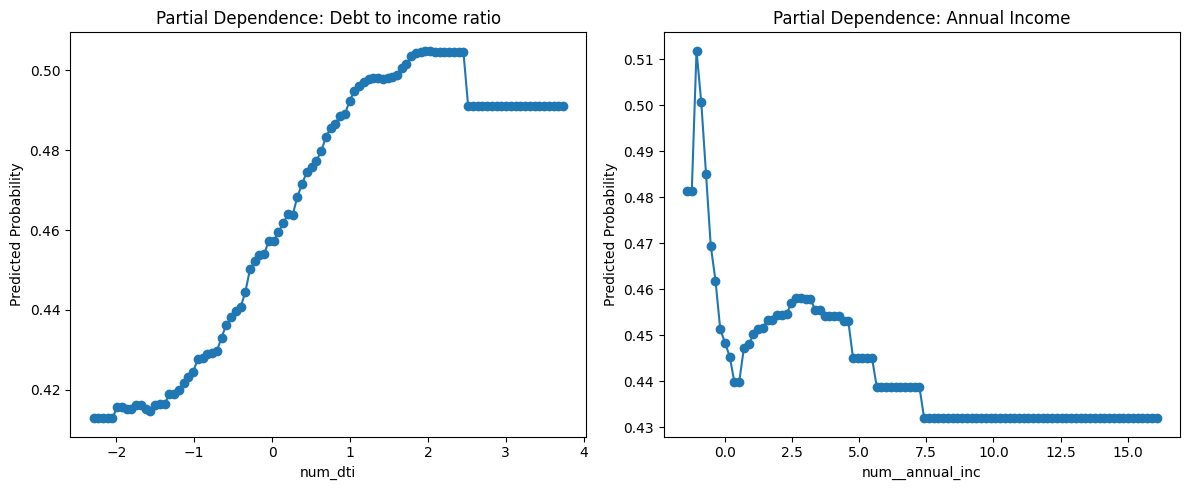

In [13]:
# We'll compute PDP manually
def partial_dependence_manual(estimator, X, feature, grid_values):
    """
    Compute partial dependence for a single feature.

    estimator: trained model (must support predict or predict_proba)
    X: DataFrame or numpy array of test data
    feature: str (column name) or int (column index)
    grid_values: array-like, values of the feature to evaluate
    """
    pdp_values = []

    for val in grid_values:
        X_temp = X.copy()
        X_temp.loc[:, feature] = val   # replace feature with fixed value
        preds = estimator.predict_proba(X_temp)[:, 1]  # probability for class 1
        pdp_values.append(np.mean(preds))  # average prediction

    return pd.DataFrame({"value": grid_values, "pdp": pdp_values})


# Example for your features
pdp_emp_title = partial_dependence_manual(catboost, X_train, "num__dti", np.linspace(X_train["num__dti"].min(),
                       X_train["num__dti"].max(), 100))
pdp_income = partial_dependence_manual(catboost, X_train, "num__annual_inc", np.linspace(X_train["num__annual_inc"].min(),
                       X_train["num__annual_inc"].max(),
                       100)
)

print(pdp_emp_title.head())
print(pdp_income.head())

# Plot PDPs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Job Title PDP
axes[0].plot(pdp_emp_title["value"], pdp_emp_title["pdp"], marker="o")
axes[0].set_title("Partial Dependence: Debt to income ratio")
axes[0].set_xlabel("num_dti")
axes[0].set_ylabel("Predicted Probability")

# Annual Income PDP
axes[1].plot(pdp_income["value"], pdp_income["pdp"], marker="o")
axes[1].set_title("Partial Dependence: Annual Income")
axes[1].set_xlabel("num__annual_inc")
axes[1].set_ylabel("Predicted Probability")

plt.tight_layout()
plt.show()

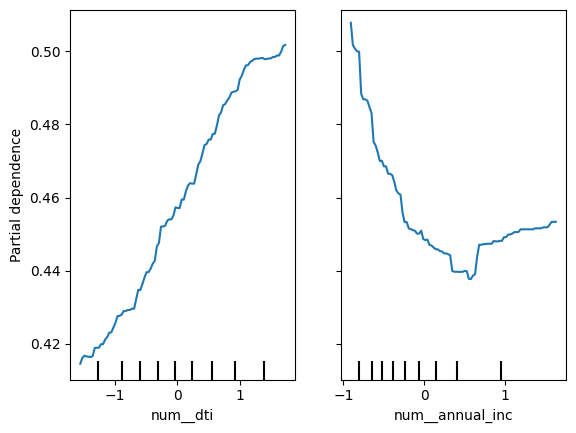

In [12]:
# Using built in function

PartialDependenceDisplay.from_estimator(
    estimator=catboost,
    X=X_train,
    features=["num__dti", "num__annual_inc"],
    grid_resolution = 100
)


## Overview of the results :
Debt-to-income ratio (DTI) measures the borrower’s ability to manage monthly debt relative to income. A higher DTI means more of their income is already committed to debt repayment.

As DTI increases, the probability of default rises steadily, peaking around 0.50 (50%). 
Higher DTI increases default risk: Borrowers with higher debt relative to income are more likely to default. This makes intuitive sense — borrowers with higher debt obligations relative to income are under more financial strain, making them riskier and more prone to default.
Furthermore, we can somehow see a plateau effect : risk rises sharply from average to moderately high DTI, but stabilizes beyond a certain threshold (~2). This suggests the model has learned that beyond a certain debt burden, additional increases don’t strongly raise default risk (possibly because most such borrowers are already “high-risk”). The model may already treat extremely high-DTI borrowers as similarly risky, so the model doesn’t differentiate much at that range. (Note : The drop in the day may be due to sample sparsity or model regularization).


As for the income, the more it increases (from 0 to ~1 on the scale), predicted default probability decreases steeply. Higher income borrowers are less likely to default.
After around 1 (mid-to-high income), the curve flattens and even slightly increases. This suggests a diminishing return effect: once income is above a certain level, extra income does not reduce default risk much further.
Income is a strong protective factor against default up to a threshold. Beyond that threshold, its effect weakens.

## Comparison with step 4 outcome:
As a reminder, in step 4 we had a positive coefficient, indicating that as DTI increases, the likelihood of default risk also increases. For the annual income, we had a negative cofficient : the higher the income, the less likely to default.

Compared to other coefficients in the chart, DTI and income have one of the largest positive effects, suggesting they are a strong and meaningful predictors in the model.


Here, we have comparable results in essence: both plots display a certain importance of these features in predicting default. For DTI, this plot indeed shows the positive relationship : the higher the DTI, the higher the risk of default. For income, the higher, the less likely to default. In both models, they are considered important factors.

However due to the simplicity of the linear regression, some subtle but important characteristics may not be displayed by the model: Linear regression suggests a simple, steady upward trend in risk with DTI. PDP shows that the relationship is not compeltly linear: risk grows rapidly in a middle range of DTI, then saturates. This indicates that DTI is indeed important, but its marginal effect diminishes once borrowers are already heavily leveraged. 

Same goes for income, where linear regression assumes this effect is linear and constant, i.e., every extra unit of income reduces risk by the same small margin. PDP shows a threshold effect: The reduction in risk is strong for low-to-moderate income borrowers. Once income is “high enough,” the marginal effect of additional income is negligible.


